# Using CNN (Convolutional Neural Network) to Classify Images of Big Cats
Prepared By: Kiana Villaera

Much of the other content in this notebook [references this notebook](https://www.kaggle.com/code/misski/big-cats-classification-acc/edit).

## Problem Statement

There are many state-of-the-art architectures out there like:
* **ResNet** a popular architecture that uses residual connections to enable training of very deep networks.
* **Inception** uses multiple parallel convolutions at different scales to capture fine-grained details in images.
* **Xception** a variant of Inception, uses depthwise separable convolutions to reduce computational complexity while maintaining accuracy.
* **MobileNet** is another efficient architecture that is designed for mobile and embedded devices.
* **EfficientNet** is a recent architecture that achieves state-of-the-art performance by automatically scaling up the network's depth, width, and resolution.

However, in this notebook, we want to come up with our own model architecture that can beat a baseline model. In all honesty, we can just use **transfer learning** and pick up a SOTA model and fine-tune it as seen in the reference notebook. However, the current goal is to deep dive into the fundamentals of CNN.

Our baseline model will be a [very vanilla implementation of CNN](https://www.tensorflow.org/tutorials/images/cnn?hl=fr) found on the Tensorflow website.

## Preliminaries

In this section we go through the fundamental knowledge needed to understand how CNN and neural networks in general work.

### What are deep neural networks?
A deep neural network is a type of machine learning model, and when it is fitted to data, this is referred to as deep learning.[[1]](https://udlbook.github.io/udlbook/) We are primarily interested in the weights that result from model training. That's what model checkpoints with a .h5 extension refer to.

![images/ai_ml_dl.PNG](images/ai_ml_dl.PNG)

**Figure 1: AI/ML/DL body of knowledge**

### What is a Convolutional Neural Network (CNN)?
A CNN is...

[CNN Explainer](https://poloclub.github.io/cnn-explainer/)
### Terminology
* A tensor can be thought of as an n-dimensional matrix. In the CNN above, tensors will be 3-dimensional with the exception of the output layer.
* A neuron can be thought of as a function that takes in multiple inputs and yields a single output.
* A layer is simply a collection of neurons with the same operation, including the same hyperparameters.
* Kernel weights and biases, while unique to each neuron, are tuned during the training phase, and allow the classifier to adapt to the problem and dataset provided.

### Hyperparameters
We will find the best hyperparameters using Tensorflow's `randomsearch`
* learning rate - reduce this for a smoother learning curve
* epoch - essentially how many passes
* batch size - increase this to allow the model to see more samples per iteration
* n_layers - how many layers
* units per layer
* dropout rate


## Evaluating Model Performance
* Accuracy
* Loss

In [12]:
# Common imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List
from glob import glob

# Data Imports
import pandas as pd
from tqdm import tqdm
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import datasets, layers, models

# Model Training
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Model Hypertunning
import keras_tuner as kt

In [2]:
# Set the directories for the dataset
train_dir = 'data/train/'
test_dir = 'data/test/'
valid_dir = 'data/valid/'

# Get all class names and count the number of classes
class_names = os.listdir(train_dir)
n_classes = len(class_names)

# Set some constants for the dataset
BATCH_SIZE = 32 # Number of samples in each batch during training
IMG_SIZE = 224 # Size of the image
AUTOTUNE = tf.data.AUTOTUNE # Set to optimize the buffer size automatically
LEARNING_RATE = 1e-3 # Learning rate for the optimizer used during model training

In [3]:
# Set the random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
def load_image(image_path: str) -> tf.Tensor:
    
    '''
    The task of the function is to load the image present in the specified given image path. Loading the image the function also performed some 
    preprocessing steps such as resizing and normalization.
    
    Argument:
        image_path(str) : This is a string which represents the location of the image file to be loaded.
        
    Returns:
        image(tf.Tensor) : This is the image which is loaded from the given image part in the form of a tensor.
    '''
    
    # Check if image path exists
    assert os.path.exists(image_path), f'Invalid image path: {image_path}'
    
    # Load the image
    image = plt.imread(image_path)
    
    # Resize the Image
    image = tfi.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    # Normalize the image to bring pixel values between 0 - 1
    image = image/255.0
    
    return image

In [5]:
def load_dataset(root_path: str, class_names: list, batch_size: int = 32, buffer_size: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Load and preprocess images from the given root path and return them as numpy arrays.

    Args:
        root_path (str): Path to the root directory where all the subdirectories (class names) are present.
        class_names (list): List of the names of all the subdirectories (class names).
        batch_size (int): Batch size of the final dataset. Defaults to 32.
        buffer_size (int): Buffer size to use when shuffling the data. Defaults to 1000.

    Returns:
        Two numpy arrays, one containing the images and the other containing their respective labels.
    '''

    # Collect total number of data samples
    n_samples = sum([len(os.listdir(os.path.join(root_path, name))) for name in class_names])

    # Create arrays to store images and labels
    images = np.empty(shape=(n_samples, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    labels = np.empty(shape=(n_samples, 1), dtype=np.int32)

    # Loop over all the image file paths, load and store the images with respective labels
    n_image = 0
    for class_name in tqdm(class_names, desc="Loading"):
        class_path = os.path.join(root_path, class_name)
        for file_path in glob(os.path.join(class_path, "*")):
            # Load the image
            image = load_image(file_path)

            # Assign label
            label = class_names.index(class_name)

            # Store the image and the respective label
            images[n_image] = image
            labels[n_image] = label

            # Increment the number of images processed
            n_image += 1

    # Shuffle the data
    indices = np.random.permutation(n_samples)
    images = images[indices]
    labels = labels[indices]

    return images, labels

In [6]:
# create model_checkpoints directory
if not os.path.isdir("model_checkpoints"):
    os.mkdir("model_checkpoints")

# Load the training dataset
X_train, y_train = load_dataset(root_path = train_dir, class_names = class_names)

# Load the validation dataset
X_valid, y_valid = load_dataset(root_path = valid_dir, class_names = class_names)

# Load the testing dataset
X_test, y_test = load_dataset(root_path = test_dir, class_names = class_names)

Loading: 100%|██████████| 10/10 [00:00<00:00, 72.98it/s]


### The Baseline Model

In [32]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 173056)           

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid, y_valid))

Epoch 1/10
74/74 [==============================] - 46s 597ms/step - loss: 1.7752 - accuracy: 0.3275 - val_loss: 1.7015 - val_accuracy: 0.4000
Epoch 2/10
74/74 [==============================] - 43s 578ms/step - loss: 1.4001 - accuracy: 0.4925 - val_loss: 1.4603 - val_accuracy: 0.4600
Epoch 3/10
74/74 [==============================] - 42s 571ms/step - loss: 0.9821 - accuracy: 0.6554 - val_loss: 1.2316 - val_accuracy: 0.5600
Epoch 4/10
74/74 [==============================] - 42s 562ms/step - loss: 0.5646 - accuracy: 0.8247 - val_loss: 1.6820 - val_accuracy: 0.5400
Epoch 5/10
74/74 [==============================] - 43s 577ms/step - loss: 0.2158 - accuracy: 0.9470 - val_loss: 2.8120 - val_accuracy: 0.4200
Epoch 6/10
74/74 [==============================] - 48s 643ms/step - loss: 0.0675 - accuracy: 0.9872 - val_loss: 2.9450 - val_accuracy: 0.5600
Epoch 7/10
74/74 [==============================] - 47s 633ms/step - loss: 0.0410 - accuracy: 0.9936 - val_loss: 2.8005 - val_accuracy: 0.5200

2/2 - 0s - loss: 2.9327 - accuracy: 0.5000 - 281ms/epoch - 141ms/step
0.5


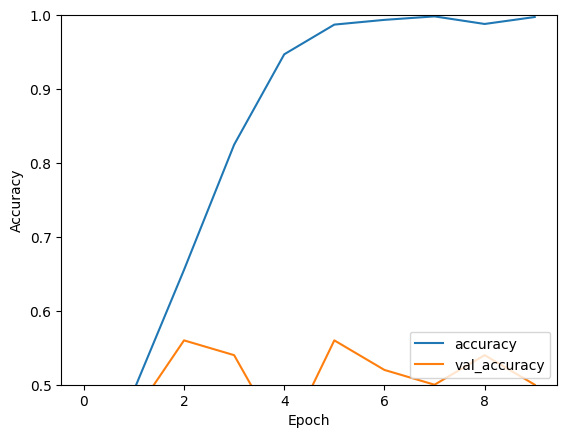

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

**The baseline accuracy therefore is 50%.**

### Improving on the Baseline Model

# References
[Prince, S. J. D. (2023). Understanding Deep Learning. MIT Press.](https://udlbook.github.io/udlbook/)